## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

import diptest

import pickle

## Helper Function

In [2]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def load_from_pickle(file_path):
    """
    Load and return the Python object from a pickle file.
    
    Parameters:
    - file_path: str, the path to the pickle file to be loaded.
    
    Returns:
    - The Python object loaded from the pickle file.
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")

def plot_raster(sd):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()

def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Synthetic Wave-Propagation Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

def unpickle_object(filename):
    """
    Deserializes and returns an object from a file using the pickle protocol.

    Parameters:
    - filename: The name of the file from which the object will be loaded.

    Returns:
    - The Python object deserialized from the file.
    """
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    return obj

## Code to implement spatial activity profile method

### Helper functions

In [3]:
def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles


def create_reverse_rank_lookup(event_ranks):
    """
    Create a reverse lookup table for event ranks.
    
    Parameters:
    - event_ranks: A dictionary mapping (neuron_id, spike_time) to event rank.
    
    Returns:
    - A dictionary mapping event rank to (neuron_id, spike_time).
    """
    reverse_lookup = {rank: (neuron_id, spike_time) for (neuron_id, spike_time), rank in event_ranks.items()}
    return reverse_lookup 

def calculate_event_ranks(spike_data, precision=5):
    # Flatten the list of spikes, rounding spike times, and sort by time
    # Include the original index of each spike for uniqueness
    all_spikes = [(neuron_id, round(spike_time, precision), idx) 
                  for neuron_id, spikes in enumerate(spike_data.train) 
                  for idx, spike_time in enumerate(spikes)]
                  
    # Sort by neuron_id, then rounded spike time, then original index
    all_spikes_sorted = sorted(all_spikes, key=lambda x: (x[1], x[0], x[2]))
    
    # Generate a dictionary with event rank as key, (neuron_id, spike_time) as value
    ranks = {rank: (neuron_id, spike_time) for rank, (neuron_id, spike_time, _) in enumerate(all_spikes_sorted)}
    
    print(f"Total unique events: {len(ranks)}")
    
    return ranks

def precompute_close_neurons(distances, window_size=17.5):
    # Initialize a dictionary to store the indices of close neurons for each neuron
    close_neurons = {}
    
    # Get the total number of neurons based on the distances matrix
    num_neurons = distances.shape[0]
    
    # Iterate over each neuron to find its close neighbors
    for i in range(num_neurons):
        # List comprehension to find neurons within the specified window size
        # Excludes the current neuron itself (i != j) and checks the distance condition
        close_neurons[i] = [
            j for j in range(num_neurons) 
            if i != j and distances[i, j] < window_size
        ]
        
    return close_neurons

def compute_bin_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints

### Look at 30 events BEFORE

In [4]:
# Looking at 30 events BEFORE

def create_distance_angle_histograms_before(spike_data, event_ranks, spatial_range=(0, 500), rank_window=30, bins=6):
    total_events = len(event_ranks)
    histograms_per_event = {}

    distances, angles = precalculate_distances_angles(get_neuron_positions(spike_data))
    
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)

    print_every_n = max(total_events // 10, 1)

    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id} of {total_events}")

        start_rank = max(0, current_event_id - rank_window)
        end_rank = current_event_id

        event_distances = []
        event_angles = []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue
            
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            # print("Distance: ", distance)
            angle = angles[current_neuron_id, other_neuron_id]
            # print("Angle: ", angle)

            if np.abs(distance) < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)
            
        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_per_event[current_event_id] = {'distance': distance_hist, 'angle': angle_hist}

    print("Processing complete")
    return histograms_per_event

### Look at 30 events AFTER

In [5]:
# Looking at 30 events AFTER

def create_distance_angle_histograms_after(spike_data, event_ranks, spatial_range=(0, 500), rank_window=30, bins=6):
    total_events = len(event_ranks)
    histograms_per_event = {}

    distances, angles = precalculate_distances_angles(get_neuron_positions(spike_data))
    
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)

    print_every_n = max(total_events // 10, 1)

    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id} of {total_events}")

        # Adjust the rank window to look at events after the current event
        start_rank = current_event_id + 1  # Start from the next event
        end_rank = min(total_events, current_event_id + rank_window + 1)  # Ensure not to exceed the total events

        event_distances = []
        event_angles = []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            angle = angles[current_neuron_id, other_neuron_id]

            if np.abs(distance) < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)
            
        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_per_event[current_event_id] = {'distance': distance_hist, 'angle': angle_hist}

    print("Processing complete")
    return histograms_per_event

### Other processing

In [6]:
def compute_average_angle_from_histogram(angle_hist):
    # Check if the histogram sum is zero
    if np.sum(angle_hist) == 0:
        # Handle the case where the histogram sum is zero
        # For example, return None or raise an error
        return np.nan  # or consider raising an error or returning a default value

    bin_width = 360 / len(angle_hist)
    bin_midpoints = np.arange(0, 360, bin_width) + bin_width / 2
    bin_midpoints_radians = np.radians(bin_midpoints)

    x_components = angle_hist * np.cos(bin_midpoints_radians)
    y_components = angle_hist * np.sin(bin_midpoints_radians)

    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians


# Function to take final histograms and calculate the average distance and angle for each event
def compute_average_distance_angle(final_histograms, spatial_range=(0, 10), bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(spatial_range[0], spatial_range[1], bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    # print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

def all_events_per_neuron(spike_data, average_distances_angles_per_event):
    all_events_per_neuron = {}

    event_ranks = calculate_event_ranks(spike_data)
    for event_id, averages in average_distances_angles_per_event.items():
        neuron_id = event_ranks[event_id][0]
        if neuron_id not in all_events_per_neuron:
            all_events_per_neuron[neuron_id] = []
        all_events_per_neuron[neuron_id].append(averages)

    return all_events_per_neuron

def average_events_per_neuron(spike_data, average_distances_angles_per_event):
    events_per_neuron = all_events_per_neuron(spike_data, average_distances_angles_per_event)
    positions = get_neuron_positions(spike_data)

    average_events_per_neuron = {}
    for neuron_id, events in events_per_neuron.items():
        angles = [event['angle'] for event in events]
        distances = [event['distance'] for event in events]

        # Calculate vector components
        x_components = [distance * np.cos(angle) for distance, angle in zip(distances, angles)]
        y_components = [distance * np.sin(angle) for distance, angle in zip(distances, angles)]

        # Calculate average vector components
        x_mean = np.mean(x_components)
        y_mean = np.mean(y_components)

        # Convert average vector components to polar coordinates
        average_distance = np.sqrt(x_mean**2 + y_mean**2)
        average_angle = np.arctan2(y_mean, x_mean)

        # # Normalize the average angle to be within 0 to 2*pi radians
        # if average_angle < 0:
        #     average_angle += 2 * np.pi

        average_events_per_neuron[neuron_id] = {'distance': average_distance, 'angle': average_angle, 'position': positions[neuron_id]}

    return average_events_per_neuron

## PLOTTER

In [7]:
def plot_data(data, title):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    # Invert y axis
    ax.invert_yaxis()
    ax.set_title(title)
    plt.show()

## Data

In [83]:
sd_random = unpickle_object('data/random_spike_data.pkl')
sd_linear = unpickle_object('data/plane_wave_spike_data.pkl')
sd_circle = unpickle_object('data/ring_wave_spike_data.pkl')
sd_loop = unpickle_object('data/rotating_circle_spike_data.pkl')

In [84]:
# Create dataframe to include all datasets as rows, and in each column, show:
# - the dataset name
# - Number of neurons
# - Duration of the recording
# - Mean firing rate

datasets = [sd_random, sd_linear, sd_circle, sd_loop]
dataset_names = ['Random', 'Plane Wave', 'Ring Wave', 'Loop Wave']

dataset_info = pd.DataFrame(columns=['Dataset', 'Number of Neurons', 'Duration (s)', 'Mean Firing Rate (Hz)'])

for sd, name in zip(datasets, dataset_names):
    num_neurons = sd.N
    duration = sd.length / 1000  # Convert milliseconds to seconds
    mean_firing_rate = np.mean(calculate_mean_firing_rates(sd))
    new_row = pd.DataFrame({'Dataset': [name],
                            'Number of Neurons': [num_neurons],
                            'Duration (s)': [duration],
                            'Mean Firing Rate (Hz)': [mean_firing_rate]})
    dataset_info = pd.concat([dataset_info, new_row], ignore_index=True)

/tmp/ipykernel_12067/643929845.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset_info = pd.concat([dataset_info, new_row], ignore_index=True)


In [85]:
def calculate_isi_stats(sd):
    isis_raw = sd.interspike_intervals()
    isis = []

    # Collect all ISIs, applying a filter for those less than 100 ms
    for isi in isis_raw:
        isis.extend([i for i in isi if i < 100])

    if isis:
        mean_isi = np.mean(isis)
        std_isi = np.std(isis)
        return mean_isi, std_isi
    else:
        return None, None  # Or handle the case of no ISIs as needed
    
def mean_median_isi(spike_data):
    """
    Calculate the mean of the median interspike intervals (ISIs) for each unit in the spike_data.

    :param spike_data: An object containing spike train data, which has a method interspike_intervals() returning a list of arrays of ISIs for each unit.
    :return: The mean of the median ISIs across all units.
    """
    # Get the list of arrays of ISIs for each unit
    isi_list = spike_data.interspike_intervals()

    # Calculate the median ISI for each unit and store them in a list
    median_isi_list = [np.median(isi) for isi in isi_list if len(isi) > 0]

    # Calculate the mean of the median ISIs
    mean_median_isi = np.mean(median_isi_list) if median_isi_list else 0

    return mean_median_isi

def median_distance(neuron_positions):
    """
    Calculate the median distance between all pairs of neurons.

    :param neuron_positions: An array of shape (n_neurons, 2) containing the x and y coordinates of the neurons.
    :return: The median distance between all neuron pairs.
    """
    # Calculate the distances between all pairs of neurons
    distances, _ = precalculate_distances_angles(neuron_positions)

    # Use only the upper triangular part of the distance matrix, excluding the diagonal
    upper_tri_distances = distances[np.triu_indices(distances.shape[0], k=1)]

    # Calculate and return the median of these distances
    median_dist = np.median(upper_tri_distances)
    return median_dist

def mean_distances(neuron_positions):
    """
    Calculate the mean distance between all pairs of neurons.

    :param neuron_positions: An array of shape (n_neurons, 2) containing the x and y coordinates of the neurons.
    :return: The mean distance between all neuron pairs.
    """
    # Calculate the distances between all pairs of neurons
    distances, _ = precalculate_distances_angles(neuron_positions)

    # Use only the upper triangular part of the distance matrix, excluding the diagonal
    upper_tri_distances = distances[np.triu_indices(distances.shape[0], k=1)]

    # Calculate and return the mean of these distances
    mean_dist = np.mean(upper_tri_distances)
    return mean_dist

In [86]:
mean_median_isi_values = [mean_median_isi(sd) for sd in datasets]

mean_distances = [mean_distances(get_neuron_positions(sd)) for sd in datasets]

# Create a new column in the dataset_info dataframe to include the mean median ISI values
dataset_info['Mean Median ISI (ms)'] = mean_median_isi_values

# Create a new column in the dataset_info dataframe to include the mean distances between neurons
dataset_info['Mean Distance Between Neurons'] = mean_distances

/tmp/ipykernel_12067/1974472676.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


In [87]:
median_distances = [median_distance(get_neuron_positions(sd)) for sd in datasets]

# Create a new column in the dataset_info dataframe to include the median distance values
dataset_info['Median Distance'] = median_distances

/tmp/ipykernel_12067/1974472676.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


In [88]:
dataset_info

,Dataset,Number of Neurons,Duration (s),Mean Firing Rate (Hz),Mean Median ISI (ms),Mean Distance Between Neurons,Median Distance
0,Random,256,60.0,3.397201,222.030737,8.358727,8.062258
1,Plane Wave,256,60.0,2.166667,21.195996,8.358727,8.062258
2,Ring Wave,256,60.0,3.233333,7.405603,8.358727,8.062258
3,Loop Wave,256,60.0,0.807813,8.165216,8.358727,8.062258


In [60]:
dataset_info['Time Window'] = 750 / np.sqrt(dataset_info['Mean Median ISI (ms)'])

In [64]:
dataset_info

,Dataset,Number of Neurons,Duration (s),Mean Firing Rate (Hz),Mean Median ISI (ms),Median Distance,Time Window
0,Random,256,60.0,3.397201,222.030737,8.062258,50.333220
1,Plane Wave,256,60.0,2.166667,21.195996,8.062258,162.904974
2,Ring Wave,256,60.0,3.233333,7.405603,8.062258,275.601160
3,Loop Wave,256,60.0,0.807813,8.165216,8.062258,262.468637


In [67]:
# Example DataFrame
df = pd.DataFrame({
    'Dataset': ['hc_328', 'hc_52', 'hc_111', 'hc_112823', 'hc_112823_2', 'hc_120523_chip21769'],
    'Mean Median ISI': [599.225368, 1650.964000, 1531.327874, 681.231225, 1249.273504, 537.614706],
    'Median Distance': [560.273371, 687.640895, 586.706911, 409.664497, 409.664497, 315.485737]
})

# Create additional column : "time window", that decreases as the mean median ISI increases - so for a mean median ISI of 8, the time window is 1000
# and for a mean median ISI of 600, the time window is 20

df['Time Window'] = 750 / np.sqrt(df['Mean Median ISI'])

# cast to int
df['Time Window'] = df['Time Window'].astype(int)

df

,Dataset,Mean Median ISI,Median Distance,Time Window
0,hc_328,599.225368,560.273371,30
1,hc_52,1650.964000,687.640895,18
2,hc_111,1531.327874,586.706911,19
3,hc_112823,681.231225,409.664497,28
4,hc_112823_2,1249.273504,409.664497,21
5,hc_120523_chip21769,537.614706,315.485737,32


# Random Data

In [76]:
random_event_ranks = calculate_event_ranks(sd_random)
random_before_histograms = create_distance_angle_histograms_before(sd_random, random_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
random_after_histograms = create_distance_angle_histograms_after(sd_random, random_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
random_before_average_distances_angles = compute_average_distance_angle(random_before_histograms, spatial_range=(0, 2), bins=6)
random_after_average_distances_angles = compute_average_distance_angle(random_after_histograms, spatial_range=(0, 2), bins=6)

random_before_average_events_per_neuron = average_events_per_neuron(sd_random, random_before_average_distances_angles)
random_after_average_events_per_neuron = average_events_per_neuron(sd_random, random_after_average_distances_angles)

Total unique events: 52181
Processing event 0 of 52181


/tmp/ipykernel_12067/1974472676.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 5218 of 52181
Processing event 10436 of 52181
Processing event 15654 of 52181
Processing event 20872 of 52181
Processing event 26090 of 52181
Processing event 31308 of 52181
Processing event 36526 of 52181
Processing event 41744 of 52181
Processing event 46962 of 52181
Processing event 52180 of 52181
Processing complete
Processing event 0 of 52181
Processing event 5218 of 52181
Processing event 10436 of 52181
Processing event 15654 of 52181
Processing event 20872 of 52181
Processing event 26090 of 52181
Processing event 31308 of 52181
Processing event 36526 of 52181
Processing event 41744 of 52181
Processing event 46962 of 52181
Processing event 52180 of 52181
Processing complete
Total unique events: 52181
Total unique events: 52181


# Linear Wave Data

In [77]:
linear_event_ranks = calculate_event_ranks(sd_linear)
linear_before_histograms = create_distance_angle_histograms_before(sd_linear, linear_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
linear_after_histograms = create_distance_angle_histograms_after(sd_linear, linear_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
linear_before_average_distances_angles = compute_average_distance_angle(linear_before_histograms, spatial_range=(0, 2), bins=6)
linear_after_average_distances_angles = compute_average_distance_angle(linear_after_histograms, spatial_range=(0, 2), bins=6)

linear_before_average_events_per_neuron = average_events_per_neuron(sd_linear, linear_before_average_distances_angles)
linear_after_average_events_per_neuron = average_events_per_neuron(sd_linear, linear_after_average_distances_angles)

Total unique events: 33280
Processing event 0 of 33280


/tmp/ipykernel_12067/1974472676.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 3328 of 33280
Processing event 6656 of 33280
Processing event 9984 of 33280
Processing event 13312 of 33280
Processing event 16640 of 33280
Processing event 19968 of 33280
Processing event 23296 of 33280
Processing event 26624 of 33280
Processing event 29952 of 33280
Processing complete
Processing event 0 of 33280
Processing event 3328 of 33280
Processing event 6656 of 33280
Processing event 9984 of 33280
Processing event 13312 of 33280
Processing event 16640 of 33280
Processing event 19968 of 33280
Processing event 23296 of 33280
Processing event 26624 of 33280
Processing event 29952 of 33280
Processing complete
Total unique events: 33280
Total unique events: 33280


# Circular Wave Data

In [78]:
circle_event_ranks = calculate_event_ranks(sd_circle)
circle_before_histograms = create_distance_angle_histograms_before(sd_circle, circle_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
circle_after_histograms = create_distance_angle_histograms_after(sd_circle, circle_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
circle_before_average_distances_angles = compute_average_distance_angle(circle_before_histograms, spatial_range=(0, 2), bins=6)
circle_after_average_distances_angles = compute_average_distance_angle(circle_after_histograms, spatial_range=(0, 2), bins=6)

circle_before_average_events_per_neuron = average_events_per_neuron(sd_circle, circle_before_average_distances_angles)
circle_after_average_events_per_neuron = average_events_per_neuron(sd_circle, circle_after_average_distances_angles)

Total unique events: 49664
Processing event 0 of 49664


/tmp/ipykernel_12067/1974472676.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 4966 of 49664
Processing event 9932 of 49664
Processing event 14898 of 49664
Processing event 19864 of 49664
Processing event 24830 of 49664
Processing event 29796 of 49664
Processing event 34762 of 49664
Processing event 39728 of 49664
Processing event 44694 of 49664
Processing event 49660 of 49664
Processing complete
Processing event 0 of 49664
Processing event 4966 of 49664
Processing event 9932 of 49664
Processing event 14898 of 49664
Processing event 19864 of 49664
Processing event 24830 of 49664
Processing event 29796 of 49664
Processing event 34762 of 49664
Processing event 39728 of 49664
Processing event 44694 of 49664
Processing event 49660 of 49664
Processing complete
Total unique events: 49664
Total unique events: 49664


# Loop Wave Data

In [79]:
loop_event_ranks = calculate_event_ranks(sd_loop)
loop_before_histograms = create_distance_angle_histograms_before(sd_loop, loop_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
loop_after_histograms = create_distance_angle_histograms_after(sd_loop, loop_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
loop_before_average_distances_angles = compute_average_distance_angle(loop_before_histograms, spatial_range=(0, 2), bins=6)
loop_after_average_distances_angles = compute_average_distance_angle(loop_after_histograms, spatial_range=(0, 2), bins=6)

loop_before_average_events_per_neuron = average_events_per_neuron(sd_loop, loop_before_average_distances_angles)
loop_after_average_events_per_neuron = average_events_per_neuron(sd_loop, loop_after_average_distances_angles)

Total unique events: 12408
Processing event 0 of 12408


/tmp/ipykernel_12067/1974472676.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 1240 of 12408
Processing event 2480 of 12408
Processing event 3720 of 12408
Processing event 4960 of 12408
Processing event 6200 of 12408
Processing event 7440 of 12408
Processing event 8680 of 12408
Processing event 9920 of 12408
Processing event 11160 of 12408
Processing event 12400 of 12408
Processing complete
Processing event 0 of 12408
Processing event 1240 of 12408
Processing event 2480 of 12408
Processing event 3720 of 12408
Processing event 4960 of 12408
Processing event 6200 of 12408
Processing event 7440 of 12408
Processing event 8680 of 12408
Processing event 9920 of 12408
Processing event 11160 of 12408
Processing event 12400 of 12408
Processing complete
Total unique events: 12408
Total unique events: 12408


In [15]:
# Pickle the datasets above
with open('data/random_before_average_events_per_neuron.pkl', 'wb') as file:
    pickle.dump(random_before_average_events_per_neuron, file)

with open('data/random_after_average_events_per_neuron.pkl', 'wb') as file:
    pickle.dump(random_after_average_events_per_neuron, file)

with open('data/linear_before_average_events_per_neuron.pkl', 'wb') as file:
    pickle.dump(linear_before_average_events_per_neuron, file)

with open('data/linear_after_average_events_per_neuron.pkl', 'wb') as file:
    pickle.dump(linear_after_average_events_per_neuron, file)

with open('data/circle_before_average_events_per_neuron.pkl', 'wb') as file:
    pickle.dump(circle_before_average_events_per_neuron, file)

with open('data/circle_after_average_events_per_neuron.pkl', 'wb') as file:
    pickle.dump(circle_after_average_events_per_neuron, file)

with open('data/loop_before_average_events_per_neuron.pkl', 'wb') as file:
    pickle.dump(loop_before_average_events_per_neuron, file)

# BIG PLOT

In [18]:
def plot_all_data(datasets, titles):
    """
    Plots all datasets in a figure with 8 subplots (2 columns, 4 rows).

    Parameters:
    - datasets: A list of dictionaries, where each dictionary represents a dataset with the same format as before.
    - titles: A list of titles for each subplot.
    """
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8, 16)) # Adjust the figsize if needed

    for idx, (data, title) in enumerate(zip(datasets, titles)):
        ax = axs[idx // 2, idx % 2] # Calculate the correct row and column index
        for key, value in data.items():
            position = np.array(value['position'])  # Ensure position is a numpy array
            angle = value['angle']
            distance = value['distance'] # Adjusting distance if needed for visualization

            # If idx is even, plot the point in pale blue; otherwise, plot the point in red
            if idx % 2 == 0:
                # Plotting the point in pale blue
                ax.plot(position[0], position[1], 'o', color='lightblue')
            else:
                # Plotting the point in red
                ax.plot(position[0], position[1], 'o', color='red')

            # Skip plotting the arrow if angle is nan
            if not np.isnan(angle):
                # Calculate the end point of the arrow
                end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
                
                # Plotting the arrow
                ax.annotate('', xy=end_point, xytext=position,
                            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
                
        ax.set_aspect('equal')
        # Invert y axis
        ax.invert_yaxis()
        ax.set_title(title)
    
    # Add legend for blue and red points
    blue_patch = Patch(color='lightblue', label='Receiver')
    red_patch = Patch(color='red', label='Sender')

    # Add legend for arrows
    arrow = FancyArrow(0, 0, 1, 1, color='black', width=0.5, head_width=5, head_length=5)
    ax.legend([blue_patch, red_patch, arrow], ['Receiver', 'Sender', 'Direction'], loc='upper right')

    plt.tight_layout()
    plt.show()

In [74]:
datasets = [
    random_before_average_events_per_neuron,
    random_after_average_events_per_neuron,
    linear_before_average_events_per_neuron,
    linear_after_average_events_per_neuron,
    circle_before_average_events_per_neuron,
    circle_after_average_events_per_neuron,
    loop_before_average_events_per_neuron,
    loop_after_average_events_per_neuron
]

titles = [
    "Random Before",
    "Random After",
    "Linear Before",
    "Linear After",
    "Circle Before",
    "Circle After",
    "Loop Before",
    "Loop After"
]

# plot_all_data(datasets, titles)

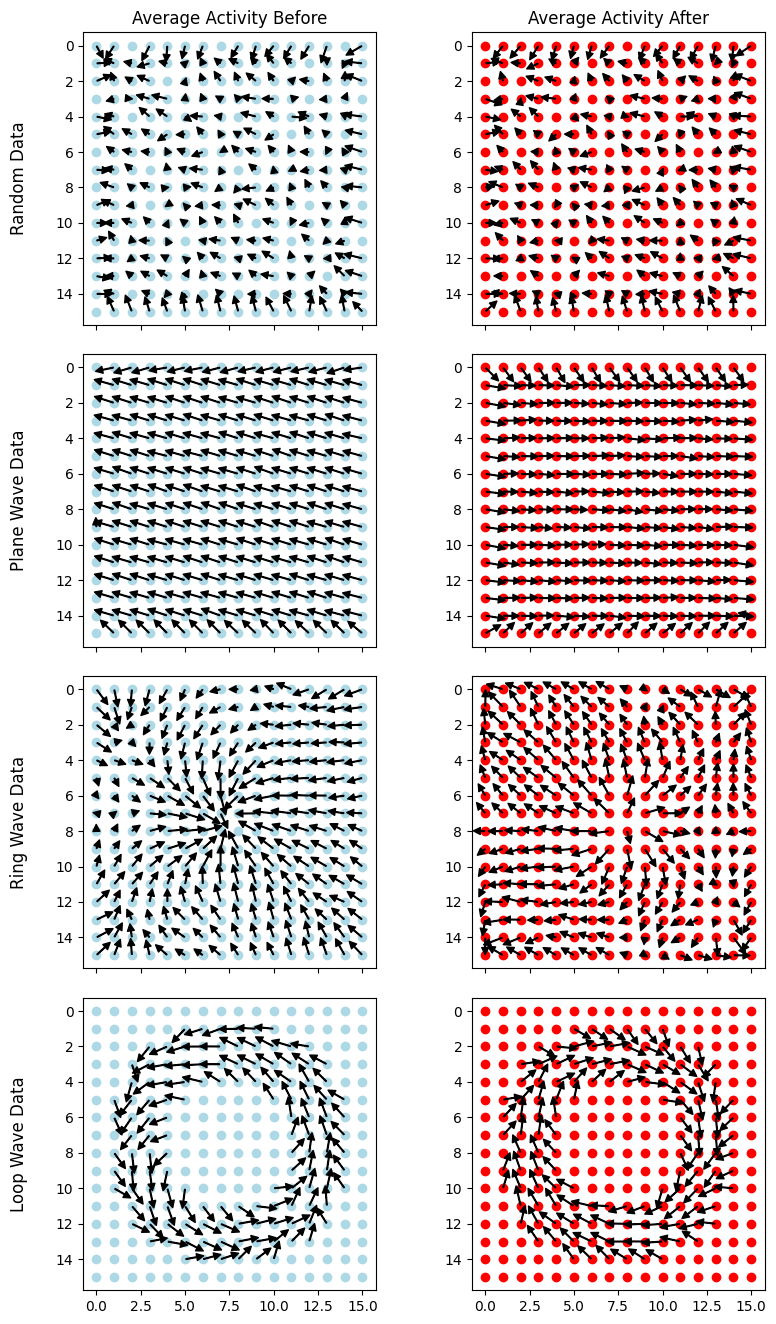

In [75]:
def plot_all_data_revised(datasets):
    """
    Plots all datasets in a figure with 8 subplots arranged in 2 columns and 4 rows, with adjusted height.
    - datasets: A list of dictionaries, where each dictionary represents a dataset.
    """
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 14.5))  # Adjusted figure size
    
    row_titles = ["Random Data", "Plane Wave Data", "Ring Wave Data", "Loop Wave Data"]  # Assuming 'Plane' is a typo for 'Linear'
    column_titles = ["Average Activity Before", "Average Activity After"]
    
    # Plot each dataset
    for idx, (data, title) in enumerate(zip(datasets, titles)):
        ax = axs[idx // 2, idx % 2] # Calculate the correct row and column index
        if idx == 6 or idx == 7:
                # Determine color based on index for the initial plotting of all positions
                color = 'lightblue' if idx % 2 == 0 else 'red'

                # Plot all positions from 0 to 15 for each dataset in the designated color
                for x in range(16):
                    for y in range(16):
                        ax.plot(x, y, 'o', color=color)
        for key, value in data.items():
            
            position = np.array(value['position'])  # Ensure position is a numpy array
            angle = value['angle']
            distance = value['distance'] # Adjusting distance if needed for visualization

            # if idx == 6 or idx == 7:
            #     # Determine color based on index for the initial plotting of all positions
            #     color = 'lightblue' if idx % 2 == 0 else 'red'

            #     # Plot all positions from 0 to 15 for each dataset in the designated color
            #     for x in range(16):
            #         for y in range(16):
            #             ax.plot(x, y, 'o', color=color, markersize=5, alpha=0.5)

            # If idx is even, plot the point in pale blue; otherwise, plot the point in red
            if idx % 2 == 0 and idx < 6:
                # Plotting the point in pale blue
                ax.plot(position[0], position[1], 'o', color='lightblue')
            else:
                if idx < 6:
                    # Plotting the point in red
                    ax.plot(position[0], position[1], 'o', color='red')

            # Skip plotting the arrow if angle is nan
            if not np.isnan(angle):
                # Calculate the end point of the arrow
                end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
                
                # Plotting the arrow
                ax.annotate('', xy=end_point, xytext=position,
                            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
                
            # Add row titles on the right or left
            if idx % 2 == 0:  # For the first column
                ax.set_ylabel(row_titles[idx // 2], rotation=90, size='large', labelpad=20)
                
        ax.set_aspect('equal')
        # Invert y axis
        ax.invert_yaxis()

        # Remove x-axis labels for all but the bottom row
        if idx // 2 != 3:
            ax.set_xticklabels([])

    # Add column titles
    for ax, col_title in zip(axs[0], column_titles):
        ax.set_title(col_title)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameters as needed

    # Reduce space between each column and row
    plt.subplots_adjust(wspace=-0.1, hspace=0.1)
    
    # Show plot
    plt.show()

# Assuming the datasets variable is predefined as in your previous message
plot_all_data_revised(datasets)